# Wikipedia Album Info Extract

Scrape Wikipedia For Albums Released by Year

In [97]:
import os
import re
from urllib.parse import urljoin
import datetime as dt

import requests
from bs4 import BeautifulSoup
import sqlite3
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%run ./url_cache.ipynb

## Initialize DB

In [3]:
os.makedirs("var/data", exist_ok=True)
db = sqlite3.Connection("var/data/music.db")

In [4]:
url_cache = URLContentCacheSqlite(db)

In [5]:
class WikipediaAlbumInfo:
    WP_ALBUM_YEAR_INDEX_URL = 'https://en.wikipedia.org/wiki/Category:Lists_of_albums_by_release_date'
    
    def __init__(self, url_cache):
        self.url_cache = url_cache

    def _get_year_urls_raw(self):
        r = self.url_cache.get(self.WP_ALBUM_YEAR_INDEX_URL)
        return r[0]

    def _parse_year_list_urls(self, html_text):
        html_doc = BeautifulSoup(html_text)
        results = []
        for a_tag in html_doc.find_all('a'):
            if 'href' in a_tag.attrs and 'title' in a_tag.attrs is not None:
                href = a_tag.attrs['href']
                title = a_tag.attrs['title']
                m = re.search(r'List of (\d+) albums', title)
                if m:
                    year = int(m.group(1))
                    results.append({
                        'year': year,
                        'title': title,
                        'url': urljoin(self.WP_ALBUM_YEAR_INDEX_URL, href)
                    })
        results = pd.DataFrame(results).sort_values(by='year', ascending=False)
        return results
    
    def get_year_urls(self):
        html_text = self._get_year_urls_raw()
        return self._parse_year_list_urls(html_text)

w_album_info = WikipediaAlbumInfo(url_cache)

## Prime List of Pages for Each Year

In [6]:
year_list_urls = w_album_info.get_year_urls()
year_list_urls

,year,title,url
18,2022,List of 2022 albums,https://en.wikipedia.org/wiki/List_of_2022_albums
17,2021,List of 2021 albums (July–December),https://en.wikipedia.org/wiki/List_of_2021_alb...
16,2021,List of 2021 albums (January–June),https://en.wikipedia.org/wiki/List_of_2021_alb...
15,2020,List of 2020 albums,https://en.wikipedia.org/wiki/List_of_2020_albums
14,2019,List of 2019 albums,https://en.wikipedia.org/wiki/List_of_2019_albums
...,...,...,...
23,1942,List of 1942 albums,https://en.wikipedia.org/wiki/List_of_1942_albums
22,1941,List of 1941 albums,https://en.wikipedia.org/wiki/List_of_1941_albums
21,1940,List of 1940 albums,https://en.wikipedia.org/wiki/List_of_1940_albums
20,1939,List of 1939 albums,https://en.wikipedia.org/wiki/List_of_1939_albums


## Parsing Albums

In [24]:
sample_year_list = year_list_urls.sample(1).iloc[0]
sample_year_list

year                                                  1992
title                                  List of 1992 albums
url      https://en.wikipedia.org/wiki/List_of_1992_albums
Name: 73, dtype: object

In [67]:
def get_table_cell_links(h):
    links = []
    for h_td in h.find_all('td'):
        for h_a in h_td.find_all('a'):
            if 'href' in h_a.attrs:
                links.append({'href': h_a.attrs['href'], 'text': h_a.text})
    links = pd.DataFrame(links)
    return links

def get_table_dataframe(h):
    return pd.read_html(str(h))[0]

def get_tables(h):
    d = BeautifulSoup(h)
    tables = []
    for t in d.find_all('table'):
        try:
            t_df = get_table_dataframe(t)
            t_links = get_table_cell_links(t)
            tables.append({ 'table': t_df, 'links': t_links })
        except Exception as e:
            print(f"Warning couldn't get table {e}")
    return tables

def get_all_tables(year_lists):
    all_tables = []

    for _, row in year_lists.iterrows():
        r = url_cache.get(row.url)
        tables = get_tables(r[0])
        for table in tables:
            all_tables.append({
                'year': row.year,
                'url': row.url,
                'table': table['table'],
                'links': table['links']
            })
            
    return all_tables

In [68]:
all_tables = get_all_tables(year_list_urls)

Warning couldn't get table invalid literal for int() with base 10: '3"'
Warning couldn't get table invalid literal for int() with base 10: '1" valign="top"'


In [71]:
all_tables[100]['table']

,Release date,Artist,Album,Genre,Label,Ref.
0,November4,Alicia Keys,Here,"R&B, soul",RCA,[652]
1,November4,B.o.B.,Elements,"Conscious hip hop, political hip hop",Label No Genre,[653]
2,November4,Bon Jovi,This House Is Not for Sale,"Arena rock, pop rock",Island,[654]
3,November4,The Chainsmokers,Collage,NaN,"Disruptor, Columbia",[655]
4,November4,Client Liaison,Diplomatic Immunity,"Electropop, indie pop, new wave","Dot Dash Recordings, Remote Control, Inertia",[656]
...,...,...,...,...,...,...
64,November25,Kate Bush,Before the Dawn,"Progressive pop, art pop, art rock","Concord, Fish People",[715]
65,November25,Kylie Minogue,Kylie Christmas: Snow Queen Edition,"Christmas, traditional pop","Parlophone, Warner Bros.",[716]
66,November25,Rumer,This Girl's in Love: A Bacharach and David Son...,Pop,"East West, Warner Bros.",[717]
67,November25,The Weeknd,Starboy,Alternative R&B,"XO, Republic",[718]


## Examining How Often Certain Columns Appear
This is to determine which fields can be used to extract data.

In [72]:
column_info = []
for tid, table in enumerate(all_tables):
    for c in table['table'].columns:
        column_info.append({ 'tid': tid, 'year': table['year'], 'column': c })
column_info = pd.DataFrame(column_info)

In [110]:
col_stats = (column_info
    .groupby(['column', 'year'])
    .size()
    .reset_index()
    .rename(columns={0: 'Count'})
    .groupby(['column'])
    .agg({'year': 'size', 'Count': 'sum'})
    .reset_index()
    .rename(columns={'year': 'YearCount'})
    .sort_values(by='Count', ascending=False)
)
col_stats['column'] = col_stats.column.astype(str)

In [112]:
pd.set_option('display.max_rows', 100)
col_stats[
    (col_stats.column.str.len() > 3) &
    (~col_stats.column.str.contains('Unnamed'))
]

,column,YearCount,Count
16,Artist,81,572
14,Album,57,499
35,Notes,42,318
42,Release date,15,179
40,Ref.,15,179
31,Label,15,179
28,Genre,15,179
24,Date,53,123
25,Date.1,22,88
18,By location,85,86


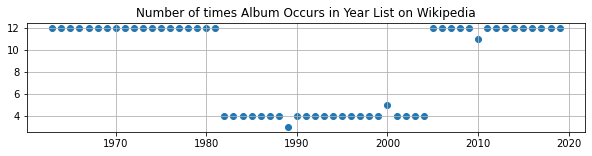

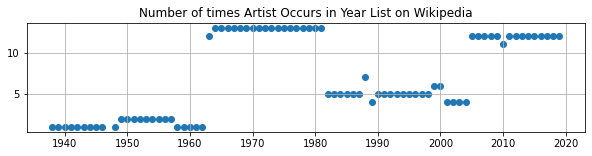

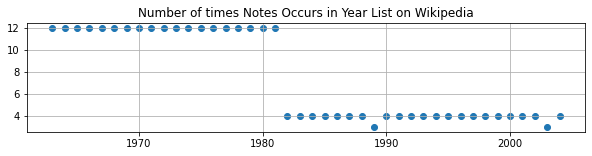

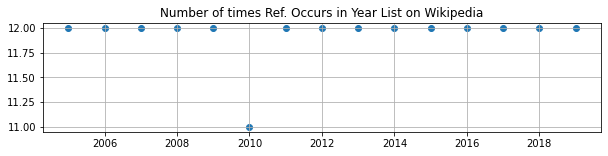

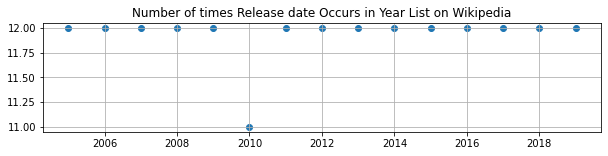

In [125]:
# It looks like the table with a column Album isn't really used prior to 1963
# The 1990s and early 2000 entries have tables by quarter while
# Many other years have tables by month.

col_stats_t5 = col_stats[
    (col_stats.column.str.len() > 3) &
    (~col_stats.column.str.contains('Unnamed'))
].head(5)

col_yc = (column_info[column_info.column.isin(set(col_stats_t5.column))]
    .groupby(['year', 'column'])
    .size()
    .reset_index()
    .rename(columns = {0: 'Count'})
    .sort_values(by=['column', 'year'])
)

for c, c_df in col_yc.groupby('column'):
    plt.figure(figsize=(10, 2))
    plt.title(f"Number of times {c} Occurs in Year List on Wikipedia")
    plt.scatter(c_df.year, c_df.Count, label=c)
    plt.grid(1)
    plt.show()

## How Are Albums represented in earlier years

In [114]:
column_info[column_info.year < 1960].column.value_counts()

0                                 33
1                                 33
Title                             33
Artist                            30
List of years in music (table)    23
Unnamed: 1                        23
Unnamed: 2                        23
2                                 23
Date                              22
Composition                       22
Composer                          22
By location                       22
Performers                        22
Location                          22
Country                           21
Year                              21
#                                 20
Chart Entries                     17
First week                         9
Number of weeks                    9
Chart entries                      4
Rank                               3
Artist(s)                          3
Song title                         1
Name: column, dtype: int64

In [126]:
column_info[column_info.year > 2020].column.value_counts()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            19
1                                       

In [129]:
for u in year_list_urls[year_list_urls.year > 2020].url:
    print(u)

https://en.wikipedia.org/wiki/List_of_2022_albums
https://en.wikipedia.org/wiki/List_of_2021_albums_(July%E2%80%93December)
https://en.wikipedia.org/wiki/List_of_2021_albums_(January%E2%80%93June)


In [130]:
for u in year_list_urls[year_list_urls.year < 1963].url:
    print(u)

https://en.wikipedia.org/wiki/List_of_1962_albums
https://en.wikipedia.org/wiki/List_of_1961_albums
https://en.wikipedia.org/wiki/List_of_1960_albums
https://en.wikipedia.org/wiki/List_of_1959_albums
https://en.wikipedia.org/wiki/List_of_1958_albums
https://en.wikipedia.org/wiki/List_of_1957_albums
https://en.wikipedia.org/wiki/List_of_1956_albums
https://en.wikipedia.org/wiki/List_of_1955_albums
https://en.wikipedia.org/wiki/List_of_1954_albums
https://en.wikipedia.org/wiki/List_of_1953_albums
https://en.wikipedia.org/wiki/List_of_1952_albums
https://en.wikipedia.org/wiki/List_of_1951_albums
https://en.wikipedia.org/wiki/List_of_1950_albums
https://en.wikipedia.org/wiki/List_of_1949_albums
https://en.wikipedia.org/wiki/List_of_1948_albums
https://en.wikipedia.org/wiki/List_of_1947_albums
https://en.wikipedia.org/wiki/List_of_1946_albums
https://en.wikipedia.org/wiki/List_of_1945_albums
https://en.wikipedia.org/wiki/List_of_1944_albums
https://en.wikipedia.org/wiki/List_of_1943_albums


In [ ]:
# Scraping after 2020 requires removing a header row for some of the tables
# Prior to 1963 the albums appear in a list instead of table